# Лабораторная работа №3. Алгоритм Гриффина-Лима

#### 1. Загрузка записи и обрезание тишины по краям

In [11]:
import librosa
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

Начальная запись.

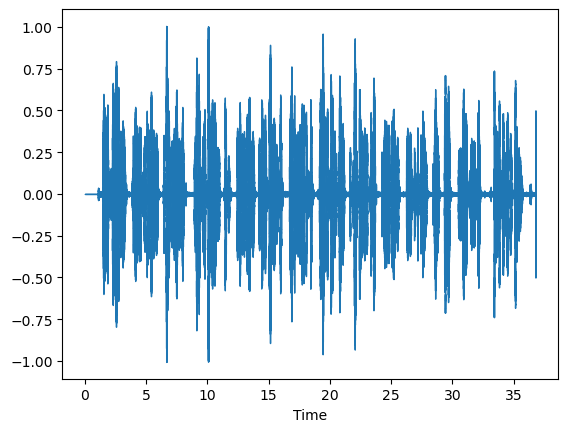

In [46]:
X, fd = librosa.load('in.mp3', sr=16000)
librosa.display.waveshow(X, sr=fd)

Запись с обрезанной тишиной в начале.

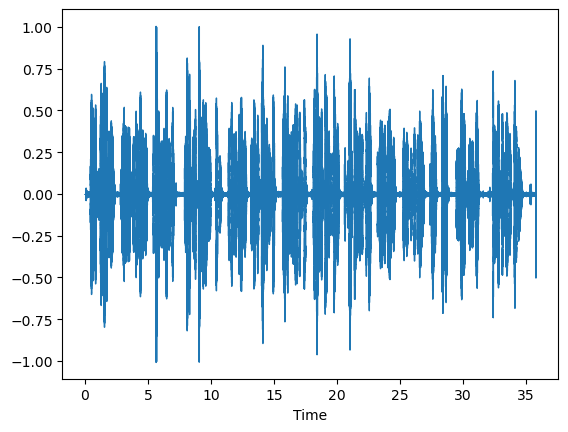

In [47]:
X, _ = librosa.effects.trim(X)
librosa.display.waveshow(X, sr=fd)

#### 2. Применение фильтра усиления высоких частот

/tmp/ipykernel_264000/3067523829.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


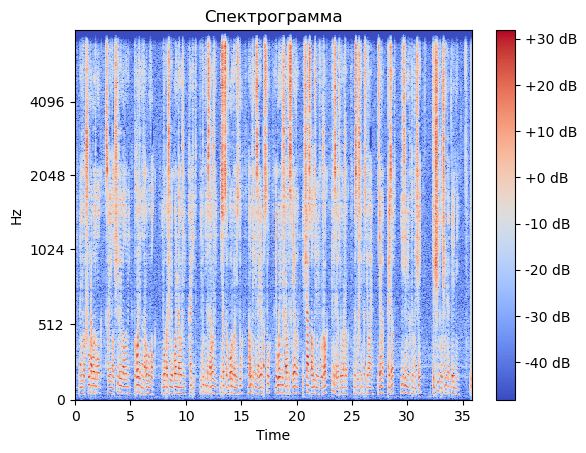

In [15]:
Y = np.append(X[0], X[1:] - 0.97 * X[:-1])
Y = librosa.stft(Y, n_fft=4096, hop_length=1024)
D = np.abs(Y)

fig, ax = plt.subplots()
DB = librosa.amplitude_to_db(D)
img = librosa.display.specshow(DB, x_axis='time', y_axis='mel', sr=fd, hop_length=1024)
fig.colorbar(img, ax=ax, format="%+1.f dB")
ax.set(title='Спектрограмма')
fig.show()

#### 3. Работа алгоритма Гриффина-Лима

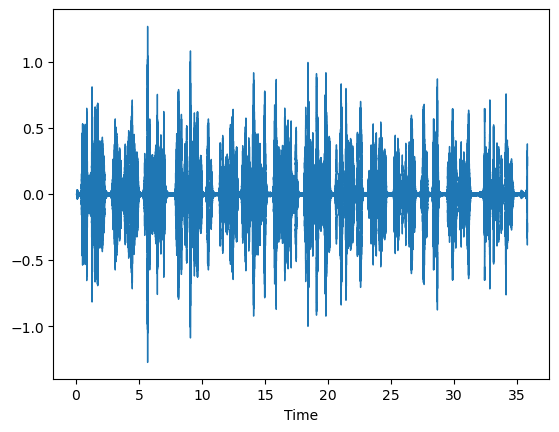

In [30]:
def GriffinLim(D, N = 4096, alpha = 0.97, hcoef = 0.25, imax=16, Filter = True):
    h = int(N * hcoef)
    D_star = D
    for i in range(imax):
        X_t = librosa.istft(D_star, n_fft=N, hop_length=h)
        E = librosa.stft(X_t, n_fft=N, hop_length=h)
        Phi = E / np.abs(E)
        D_star = D * Phi
    X_t = librosa.istft(D_star, n_fft=N, hop_length=h)
    X_out = X_t.real
    if Filter:
        X_out = signal.lfilter([1], [1, -alpha], X_out)
    return X_out

X_new = GriffinLim(D)

import soundfile as sf
librosa.display.waveshow(X_new, sr=fd)
sf.write('out.wav', X_new, fd)

In [39]:
def algo(signal, N = 4096, alpha = 0.97, hcoef = 0.5, imax = 64, Filter = True):
    Y = signal
    if Filter:
        Y = np.append(signal[0], signal[1:] - alpha * signal[:-1])
    Y = librosa.stft(Y, n_fft=N, hop_length=int(N * hcoef))
    D = np.abs(Y)
    X_out = GriffinLim(D, N, alpha, hcoef, imax, Filter)
    return X_out

#### 4. Использование фильтра усиления высоких частот и его параметра $\alpha$.

In [40]:
X_new = algo(X, 4096, 0, 0.5, 64, False)
print("СКО без фильтра:", np.mean((X[:len(X_new)] - X_new) ** 2))

for alph in [0.95, 0.96, 0.97]:
    X_new = algo(X, 4096, alph, 0.5, 64, True)
    print("Alpha", alph, ": СКО", np.mean((X[:len(X_new)] - X_new) ** 2))

СКО без фильтра: 0.02982183
Alpha 0.95 : СКО 0.028487030769920655
Alpha 0.96 : СКО 0.028524148266180646
Alpha 0.97 : СКО 0.0284610253325738


Среднеквадратичное отклонение без фильтра усиления высоких частот больше, чем на 4% по сравнению с результатами с фильтрами. Самое малое СКО получилось при $\alpha=0.97$.

#### 5. Исследование влияния размерности дискретного преобразования Фурье

In [41]:
for N in [512, 1024, 2048, 4096]:
    X_new = algo(X, N, 0.97, 0.5, 64, True)
    print("Размерность ",N,": СКО", np.mean((X[:len(X_new)] - X_new) ** 2))

Размерность  512 : СКО 0.029008365668732147
Размерность  1024 : СКО 0.029764612229730116
Размерность  2048 : СКО 0.027010679101604207
Размерность  4096 : СКО 0.0284610253325738


Для сигнала наилучшей размерностью оказалась N = 2048 (которое имеет наименьшее СКО среди других вариантов).

#### 6. Иследование влияния величины сдвига

In [42]:
for hcoef in [0.25, 0.5, 1]:
    X_new = algo(X, 2048, 0.97, hcoef, 64, True)
    print("Offset", hcoef, ": СКО", np.mean((X[:len(X_new)] - X_new) ** 2))

Offset 0.25 : СКО 0.028351915290546394
Offset 0.5 : СКО 0.027010679101604207
Offset 1 : СКО 113852612.23781207


Наименьшее СКО при сдвиге 0.5. При сдвиге 1 алгоритм отрабатывает с ошибкой.

#### 7. Исследование влияния числа итераций алгоритма Гриффина-Лима

In [45]:
for imax in [16, 32, 64, 128, 256]:
    X_new = algo(X, 2048, 0.97, 0.5, imax, True)
    print("imax ",imax, ": СКО",np.mean((X[:len(X_new)] - X_new) ** 2))

imax  16 : СКО 0.027444352678715315
imax  32 : СКО 0.02721859850232696
imax  64 : СКО 0.027010679101604207
imax  128 : СКО 0.02677453293569004
imax  256 : СКО 0.026502230504885805


При числе итераций 256 получилось наименьшее СКО. Также можно заметить, что с увеличением числа итераций СКО уменьшается.